In [1]:
import os

%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

In [2]:
noisy_data_path = '../train'
clean_data_path = '../train_cleaned'
test_data = '../test'

'../test'

In [3]:
def get_img_filepaths(parent_dir):
    walker = os.walk(parent_dir)
    filepaths = []
    for root, _, files in walker:
        for file in files:
            filepaths.append(os.path.join(root, file))

    print(f"Sample of filepaths: {filepaths[:5]}")
    print(len(filepaths))

    return filepaths

In [4]:
noisy_img_filepaths = get_img_filepaths(noisy_data_path)
truth_img_filepaths = get_img_filepaths(clean_data_path)

Sample of filepaths: ['../train/12.png', '../train/179.png', '../train/165.png', '../train/195.png', '../train/149.png']
144
Sample of filepaths: ['../train_cleaned/12.png', '../train_cleaned/179.png', '../train_cleaned/165.png', '../train_cleaned/195.png', '../train_cleaned/149.png']
144


['../train_cleaned/12.png',
 '../train_cleaned/179.png',
 '../train_cleaned/165.png',
 '../train_cleaned/195.png',
 '../train_cleaned/149.png',
 '../train_cleaned/108.png',
 '../train_cleaned/62.png',
 '../train_cleaned/191.png',
 '../train_cleaned/170.png',
 '../train_cleaned/210.png',
 '../train_cleaned/15.png',
 '../train_cleaned/92.png',
 '../train_cleaned/155.png',
 '../train_cleaned/99.png',
 '../train_cleaned/138.png',
 '../train_cleaned/87.png',
 '../train_cleaned/158.png',
 '../train_cleaned/39.png',
 '../train_cleaned/36.png',
 '../train_cleaned/78.png',
 '../train_cleaned/204.png',
 '../train_cleaned/122.png',
 '../train_cleaned/105.png',
 '../train_cleaned/167.png',
 '../train_cleaned/32.png',
 '../train_cleaned/147.png',
 '../train_cleaned/156.png',
 '../train_cleaned/81.png',
 '../train_cleaned/86.png',
 '../train_cleaned/176.png',
 '../train_cleaned/17.png',
 '../train_cleaned/206.png',
 '../train_cleaned/153.png',
 '../train_cleaned/14.png',
 '../train_cleaned/5.png',
 

In [5]:
import cv2 as cv
from PIL import Image

noisy_images = [Image.open(filepath) for filepath in noisy_img_filepaths]
clean_images = [Image.open(filepath) for filepath in truth_img_filepaths]
img_sizes = set([img.size for img in noisy_images])
img_modes = set([img.mode for img in noisy_images])
print(f"Image sizes: {img_sizes} image modes: {img_modes}")

Image sizes: {(540, 420), (540, 258)} image modes: {'L'}


In [6]:
for shape in img_sizes:
    a, b = shape
    print(f"Image shape: {a}x{b} = {a*b} pixels")

Image shape: 540x420 = 226800 pixels
Image shape: 540x258 = 139320 pixels


In [7]:
ideal_imshape = (420,540)
epochs = 10
lr = 0.001

0.001

In [8]:
print(f"{len(noisy_images)} total training images")

144 total training images


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda


In [10]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=0),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=1, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
transforms = transforms.Compose([
    transforms.Resize(ideal_imshape),
    transforms.ToTensor()
])

Compose(
    Resize(size=(420, 540), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)

In [12]:
class DenoisedDataset(Dataset):
    def __init__(self, clean_parent_dir, noisy_parent_dir, transforms=None, isGrayscale=True):
        self.transforms = transforms
        self.clean_images = get_img_filepaths(clean_parent_dir)
        self.noisy_images = get_img_filepaths(noisy_parent_dir)
        self.isGrayscale = isGrayscale
    def __len__(self):
        return len(self.clean_images)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        clean_img = Image.open(self.clean_images[idx])
        noisy_img = Image.open(self.noisy_images[idx])
        return self.transforms(noisy_img), self.transforms(clean_img)

In [13]:
train_ds = DenoisedDataset(clean_data_path, noisy_data_path, transforms=transforms)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

test_ds = DenoisedDataset(test_data, test_data, transforms=transforms)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False)

model = AutoEncoder().to(device)
print(f"Model size: {sum(p.numel() for p in model.parameters())}")
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

Sample of filepaths: ['../train_cleaned/12.png', '../train_cleaned/179.png', '../train_cleaned/165.png', '../train_cleaned/195.png', '../train_cleaned/149.png']
144
Sample of filepaths: ['../train/12.png', '../train/179.png', '../train/165.png', '../train/195.png', '../train/149.png']
144
Sample of filepaths: ['../test/106.png', '../test/46.png', '../test/43.png', '../test/169.png', '../test/190.png']
72
Sample of filepaths: ['../test/106.png', '../test/46.png', '../test/43.png', '../test/169.png', '../test/190.png']
72


Model size: 46529


MSELoss()

In [14]:
import time

start_time = time.time()
for epoch in range(epochs):
    running_loss = 0.0
    batch_count = 0
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)

        preds = model(images)
        loss = criterion(preds, labels)

        batch_count += 1
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs} | loss: {running_loss/batch_count:.5f} | time: {time.time()-start_time:.2f}s")

print(f"\nTraining complete! \nTotal time: {time.time()-start_time:.2f}s. \nAvg time per epoch: {(time.time()-start_time)/epochs:.2f}s")


Epoch 1/10 | loss: 0.10469 | time: 2.52s
Epoch 2/10 | loss: 0.07971 | time: 4.37s
Epoch 3/10 | loss: 0.06387 | time: 6.23s
Epoch 4/10 | loss: 0.04598 | time: 8.08s
Epoch 5/10 | loss: 0.02523 | time: 9.94s
Epoch 6/10 | loss: 0.01692 | time: 11.79s
Epoch 7/10 | loss: 0.01165 | time: 13.63s
Epoch 8/10 | loss: 0.00799 | time: 15.49s
Epoch 9/10 | loss: 0.00614 | time: 17.33s
Epoch 10/10 | loss: 0.00514 | time: 19.18s

Training complete! 
Total time: 19.18s. 
Avg time per epoch: 1.92s


In [15]:
import random
import matplotlib.pyplot as plt

def show_images(images, labels, preds, num_images=5):
    for i in range(num_images):
        idx = random.randint(0, len(images)-1)
        img = images[idx].squeeze().cpu().detach().numpy()
        label = labels[idx].squeeze().cpu().detach().numpy()
        pred = preds[idx].squeeze().cpu().detach().numpy()

        fig, ax = plt.subplots(1, 3, figsize=(15,5))
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Noisy Image')
        ax[1].imshow(label, cmap='gray')
        ax[1].set_title('Clean Image')
        ax[2].imshow(pred, cmap='gray')
        ax[2].set_title('Denoised Image')
        plt.show()

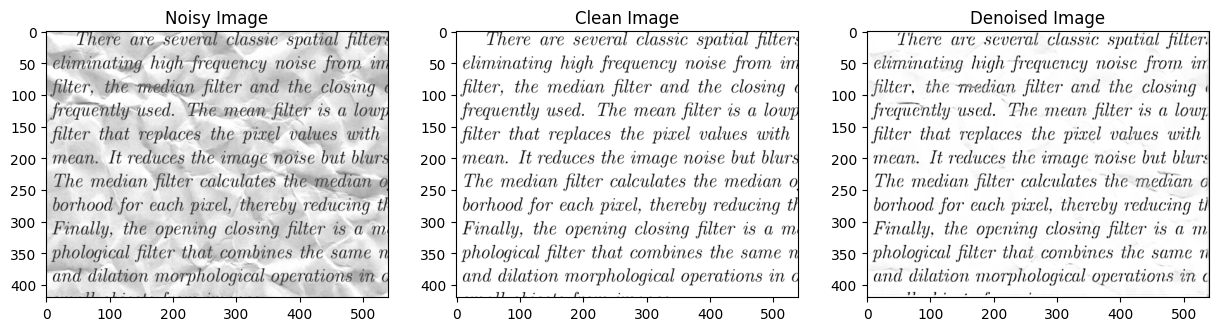

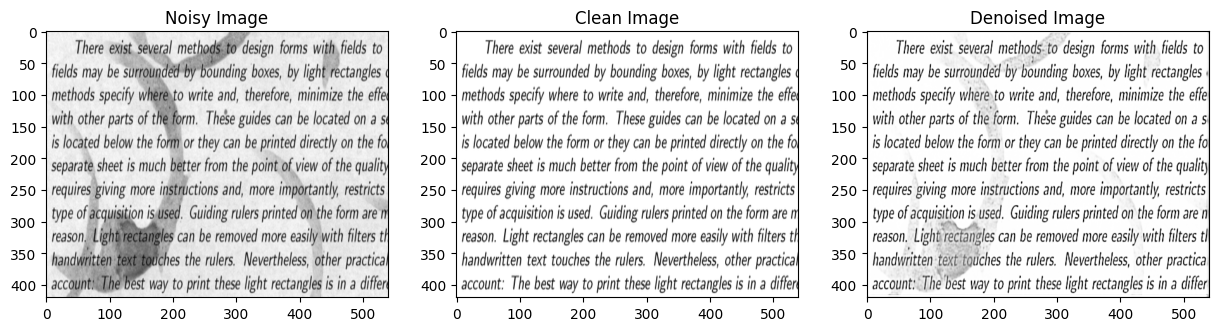

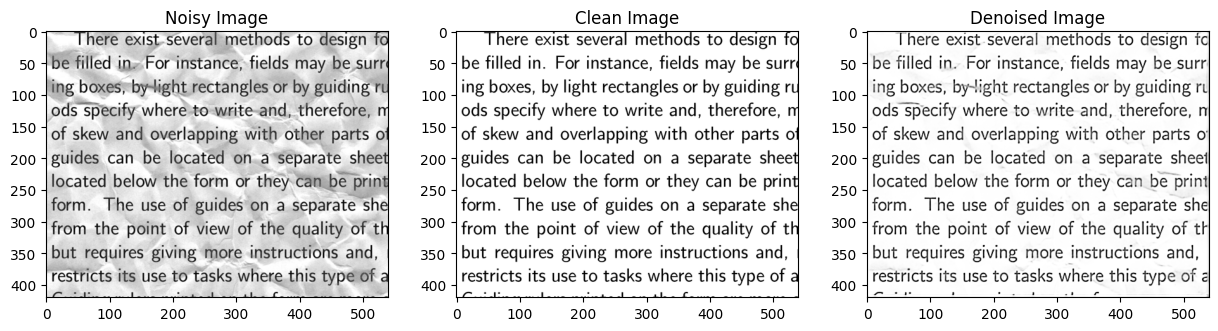

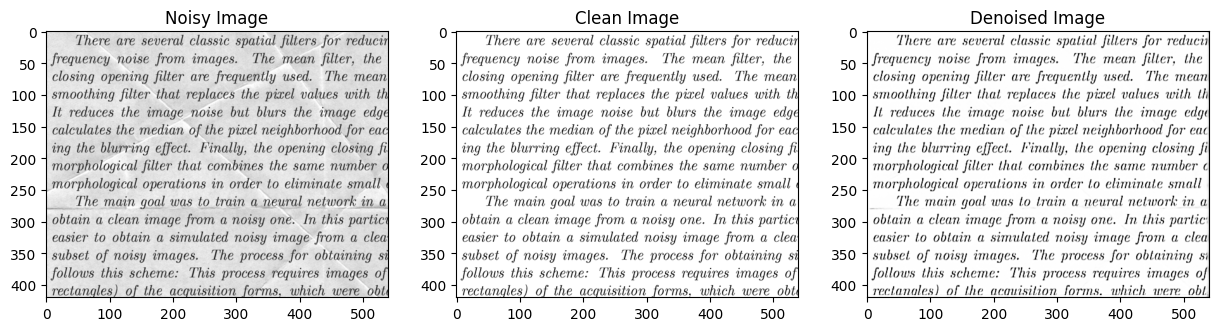

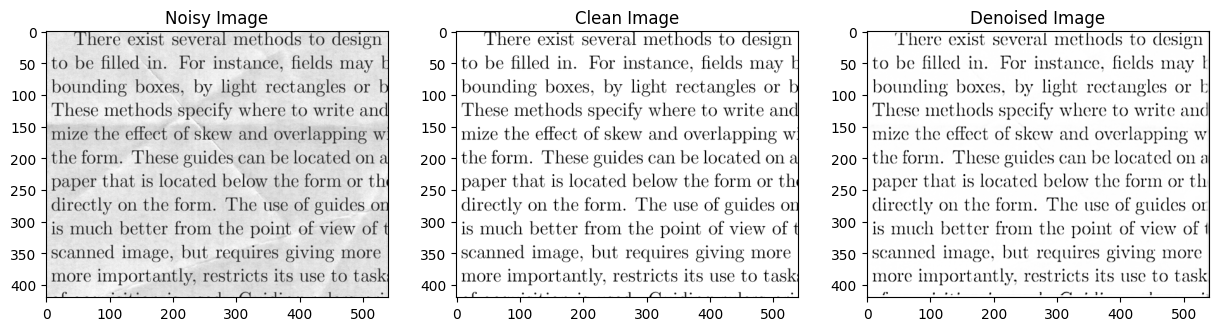

In [16]:
with torch.no_grad():
    model.eval()
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        show_images(images, labels, preds)
        break

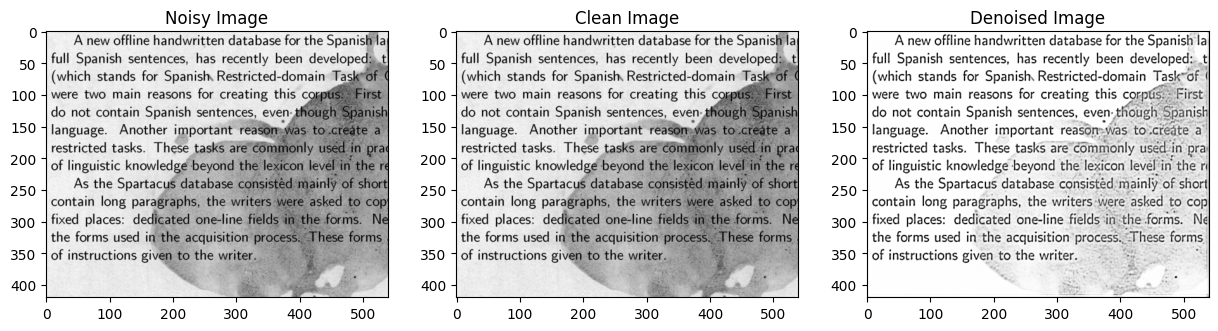

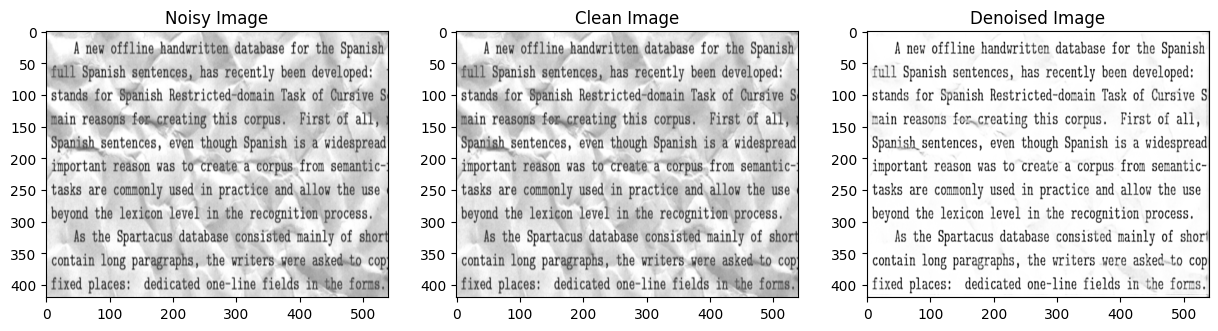

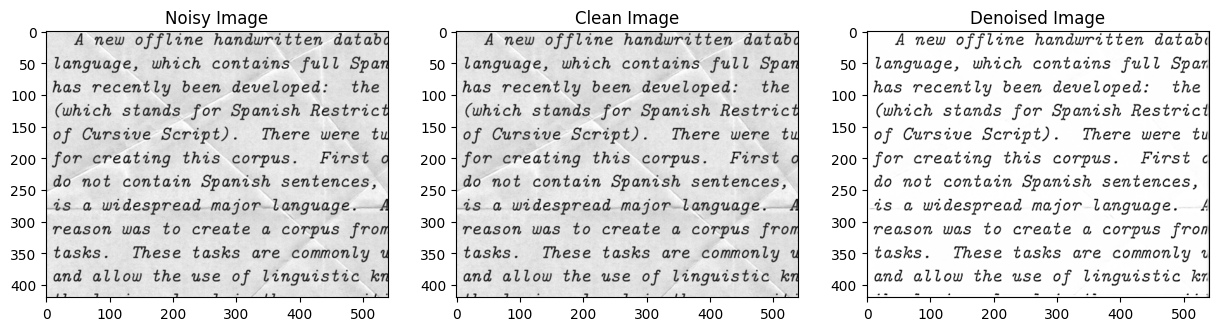

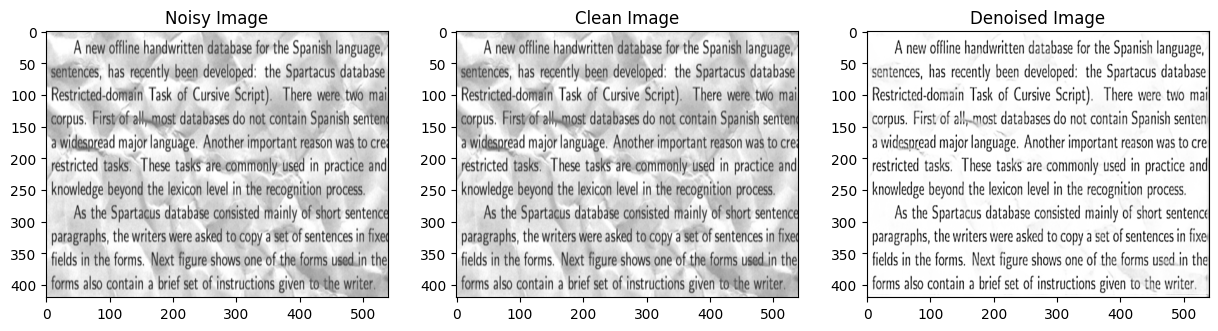

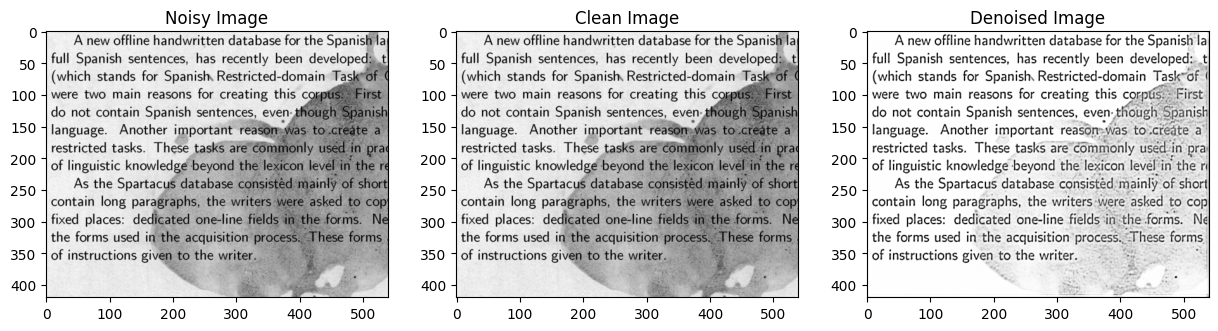

In [17]:
with torch.no_grad():
    model.eval()
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        show_images(images, labels, preds)
        break